Step 1: select small dataset from largedataset

In [1]:
import pandas as pd

# Load your original dataset
df = pd.read_csv("financial_risk_data.csv")

# Take only first 500 rows
df_small = df.head(500)

# Save it as a new file
df_small.to_csv("small_dataset.csv", index=False)


C:\Users\Zain Latif\AppData\Local\Temp\ipykernel_3448\488363330.py:4: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("financial_risk_data.csv")


Step 2: show overview of small dataset 

In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv("small_dataset.csv")

# Basic shape of the data
print("🧾 Dataset Shape:", df.shape)

# First 5 rows
print("\n🔍 First 5 Rows:")
display(df.head())

# Info about columns and data types
print("\nℹ️ Dataset Info:")
df.info()

# Summary statistics for numeric columns
print("\n📊 Summary Statistics:")
display(df.describe())

# Check for missing values
print("\n❗ Missing Values in Each Column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\n📋 Number of Duplicate Rows:", df.duplicated().sum())

# Display column names
print("\n🪶 Column Names:")
print(df.columns.tolist())


🧾 Dataset Shape: (500, 151)

🔍 First 5 Rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN



ℹ️ Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 151 entries, id to settlement_term
dtypes: float64(115), int64(1), object(35)
memory usage: 590.0+ KB

📊 Summary Statistics:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,desc,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,5.000000e+02,0.0,500.000,500.000,500.000,500.000000,500.000000,500.000000,0.0,500.00000,...,7.0,7.000000,7.0,7.000000,6.000000,7.000000,7.000000,10.000000,10.000000,10.000000
mean,6.835821e+07,NaN,15407.800,15407.800,15407.800,11.965780,445.209120,78135.284420,NaN,19.54462,...,3.0,100.941429,3.0,12.428571,329.790000,9781.795714,177.362857,5120.100000,47.003000,10.200000
std,3.957689e+05,NaN,8466.271,8466.271,8466.271,4.211259,248.164527,38412.259878,NaN,8.43339,...,0.0,73.373282,0.0,12.272695,228.112335,6816.483210,271.555792,3693.703034,3.495721,6.268085
min,6.622095e+07,NaN,1400.000,1400.000,1400.000,5.320000,45.970000,13000.000000,NaN,0.63000,...,3.0,36.070000,3.0,0.000000,108.210000,3058.140000,1.960000,1203.000000,44.990000,1.000000
25%,6.837634e+07,NaN,8706.250,8706.250,8706.250,8.490000,263.120000,52000.000000,NaN,13.38250,...,3.0,46.935000,3.0,0.000000,141.045000,4340.360000,30.890000,2949.000000,45.000000,6.500000
50%,6.844652e+07,NaN,15000.000,15000.000,15000.000,11.480000,386.090000,70000.000000,NaN,18.64500,...,3.0,47.480000,3.0,16.000000,292.425000,7153.150000,61.230000,4352.500000,45.005000,11.000000
75%,6.853723e+07,NaN,20000.000,20000.000,20000.000,14.850000,578.425000,97000.000000,NaN,25.32500,...,3.0,157.595000,3.0,22.000000,487.972500,15388.145000,179.850000,4486.000000,48.755000,15.000000
max,6.861706e+07,NaN,35000.000,35000.000,35000.000,27.490000,1252.560000,300000.000000,NaN,39.56000,...,3.0,213.980000,3.0,27.000000,641.940000,18804.270000,756.870000,13403.000000,55.000000,18.000000



❗ Missing Values in Each Column:
id                         0
member_id                500
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
                        ... 
settlement_status        490
settlement_date          490
settlement_amount        490
settlement_percentage    490
settlement_term          490
Length: 151, dtype: int64

📋 Number of Duplicate Rows: 0

🪶 Column Names:
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', '

Step 3: Data cleaning and fill data

In [3]:
# ---------------- STEP 3: CLEANING & PREPROCESSING (paste into your notebook) ----------------
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------- CONFIG ----------
TARGET_COL = 'loan_status'   # change if different
ID_COLS = ['id', 'member_id', 'url', 'title', 'zip_code', 'desc']  # drop these if present
MAX_MISSING_RATIO = 0.80     # drop columns with >80% missing
CAT_CARDINALITY_LIMIT = 15   # only one-hot encode categoricals with unique <= this
TEST_SIZE_FRACTION = 0.20    # fallback fraction for larger datasets
RANDOM_STATE = 42
# ----------------------------

# Copy df to avoid accidental mutation
df_clean = df.copy()

print("Initial shape:", df_clean.shape)

# 1) Drop columns with too many missing values
missing_ratio = df_clean.isna().mean()
cols_to_drop = missing_ratio[missing_ratio > MAX_MISSING_RATIO].index.tolist()
print(f"Dropping {len(cols_to_drop)} columns with >{int(MAX_MISSING_RATIO*100)}% missing.")
df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2) Drop obvious identifier columns if present
existing_ids = [c for c in ID_COLS if c in df_clean.columns]
if existing_ids:
    print("Dropping identifier cols:", existing_ids)
    df_clean.drop(columns=existing_ids, inplace=True, errors='ignore')

print("Shape after column drops:", df_clean.shape)

# 3) Normalize / prepare some known columns
# 3a) term -> months (e.g. '36 months' -> 36)
if 'term' in df_clean.columns:
    df_clean['term_months'] = df_clean['term'].astype(str).str.extract(r'(\d+)').astype(float)
    df_clean.drop(columns=['term'], inplace=True, errors='ignore')

# 3b) percent-like columns that might be strings with '%' (int_rate, revol_util, sec_app_revol_util, etc.)
percent_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object' and df_clean[c].astype(str).str.contains('%').any()]
# also include common percent-named columns if present
for c in ['int_rate', 'revol_util', 'sec_app_revol_util']:
    if c in df_clean.columns and df_clean[c].dtype == object:
        percent_cols.append(c)
percent_cols = list(set(percent_cols))
for c in percent_cols:
    try:
        df_clean[c] = df_clean[c].astype(str).str.replace('%', '').str.strip()
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')
        print(f"Converted percent-col -> numeric: {c}")
    except Exception as e:
        print("Could not convert percent col:", c, "->", e)

# 3c) If int_rate already numeric but in form '13.99' it's fine. If still object, try to coerce.
if 'int_rate' in df_clean.columns and not np.issubdtype(df_clean['int_rate'].dtype, np.number):
    df_clean['int_rate'] = pd.to_numeric(df_clean['int_rate'], errors='coerce')

# 4) Prepare target (binary)
if TARGET_COL not in df_clean.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataframe.")

# If already numeric and 0/1 -> use directly; otherwise map common labels
if pd.api.types.is_numeric_dtype(df_clean[TARGET_COL].dtype):
    unique_vals = np.unique(df_clean[TARGET_COL].dropna().astype(int))
    if set(unique_vals).issubset({0, 1}):
        df_clean['target'] = df_clean[TARGET_COL].astype(int)
        print("Target already binary numeric (0/1).")
    else:
        # fallback: treat non-zero as 1
        df_clean['target'] = (df_clean[TARGET_COL] != 0).astype(int)
        print("Target numeric but not 0/1; mapped non-zero -> 1.")
else:
    # common label mapping (adjust if your dataset uses different labels)
    label_map = {
        'Fully Paid': 0,
        'Current': 0,
        'In Grace Period': 0,
        'Late (16-30 days)': 1,
        'Late (31-120 days)': 1,
        'Charged Off': 1,
        'Default': 1,
        'charged off': 1,
        'Fully Paid.': 0
    }
    unknown_labels = set(df_clean[TARGET_COL].dropna().unique()) - set(label_map.keys())
    if unknown_labels:
        print("Warning: Unknown target labels found (will be dropped):", unknown_labels)
    df_clean['target'] = df_clean[TARGET_COL].map(label_map)
    # drop rows where mapping failed
    before_rows = len(df_clean)
    df_clean = df_clean[df_clean['target'].notna()].copy()
    print(f"Dropped {before_rows - len(df_clean)} rows with unmapped target labels.")

# convert to int
df_clean['target'] = df_clean['target'].astype(int)
print("Target distribution:\n", df_clean['target'].value_counts())

# 5) Feature selection: numeric features + select low-cardinality categorical features
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# remove target from numeric features
numeric_cols = [c for c in numeric_cols if c not in ['target']]

# candidate categorical columns (object / category types)
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# keep only low-cardinality categorical columns for one-hot
cat_keep = []
for c in cat_cols:
    n_unique = df_clean[c].nunique(dropna=True)
    if 1 < n_unique <= CAT_CARDINALITY_LIMIT:
        cat_keep.append(c)

print(f"Selected {len(numeric_cols)} numeric features and {len(cat_keep)} categorical features for encoding.")
print("Numeric (sample):", numeric_cols[:10])
print("Categorical to encode (sample):", cat_keep[:10])

# Build X
X_num = df_clean[numeric_cols].copy()
X_cat = df_clean[cat_keep].copy() if cat_keep else pd.DataFrame(index=df_clean.index)

# 6) Impute numeric with median
num_imputer = SimpleImputer(strategy='median')
if not X_num.empty:
    X_num_imputed = pd.DataFrame(num_imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)
else:
    X_num_imputed = X_num

# 7) Fill categorical missing with 'MISSING' and one-hot encode
if not X_cat.empty:
    X_cat_filled = X_cat.fillna('MISSING').astype(str)
    X_cat_encoded = pd.get_dummies(X_cat_filled, drop_first=True)
else:
    X_cat_encoded = pd.DataFrame(index=X_num_imputed.index)

# 8) Combine numeric + categorical
X = pd.concat([X_num_imputed, X_cat_encoded], axis=1)
print("Final feature matrix shape (before scaling):", X.shape)

# 9) Safety check - if X has any NaN (shouldn't) replace with median fallback
if X.isna().any().any():
    print("Warning: NaNs found in X after imputation. Applying median fallback for remaining NaNs.")
    X = pd.DataFrame(num_imputer.fit_transform(X), columns=X.columns, index=X.index)

# 10) Optional scaling (helpful for many models)
scaler = StandardScaler()
if X.shape[1] > 0:
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
else:
    X_scaled = X

# 11) Prepare y and safe train-test split (absolute test count)
y = df_clean['target'].reset_index(drop=True)
X_scaled = X_scaled.reset_index(drop=True)

n_samples = len(X_scaled)
if n_samples == 0:
    raise ValueError("No samples available after preprocessing.")

n_test = max(1, int(round(TEST_SIZE_FRACTION * n_samples)))
if n_test >= n_samples:
    n_test = n_samples - 1
print(f"Using absolute test size = {n_test} of {n_samples} samples.")

# stratify if each class has >=2 samples
stratify_arg = None
vc = y.value_counts()
if vc.min() >= 2:
    stratify_arg = y
    print("Using stratified split.")
else:
    print("Not enough samples per class to stratify; doing random split.")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=n_test, random_state=RANDOM_STATE, stratify=stratify_arg
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts())
print("Test target distribution:\n", y_test.value_counts())

# 12) Save processed datasets into workspace variables for next step
processed = {
    'X_train': X_train, 'X_test': X_test,
    'y_train': y_train, 'y_test': y_test,
    'X_all': X_scaled, 'y_all': y
}
print("Preprocessing complete. Processed dict created for model training (use processed['X_train'] etc.).")
# ----------------------------------------------------------------------------------------------


Initial shape: (500, 151)
Dropping 40 columns with >80% missing.
Dropping identifier cols: ['id', 'url', 'title', 'zip_code']
Shape after column drops: (500, 107)
Dropped 0 rows with unmapped target labels.
Target distribution:
 target
0    423
1     77
Name: count, dtype: int64
Selected 88 numeric features and 9 categorical features for encoding.
Numeric (sample): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high']
Categorical to encode (sample): ['grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type', 'debt_settlement_flag']
Final feature matrix shape (before scaling): (500, 126)
Using absolute test size = 100 of 500 samples.
Using stratified split.
Train shape: (400, 126) Test shape: (100, 126)
Train target distribution:
 target
0    338
1     62
Name: count, dtype: int64
Test target distribution:
 target
0    85

Step 4: Model Training & Evaluation (Logistic Regression)


Training shape: (400, 126), Testing shape: (100, 126)

✅ Model Evaluation Results:
Accuracy: 1.000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        15

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



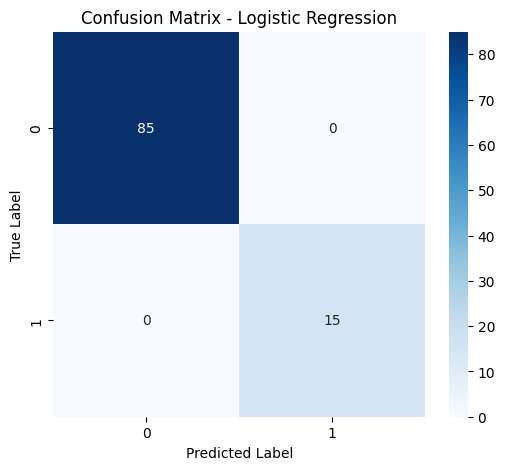

Model saved as model.pkl ✅


In [4]:
# 🧠 Step 4: Model Training & Evaluation (Logistic Regression)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧩 Extract processed data from your step 3 dictionary
X_train = processed["X_train"]
X_test = processed["X_test"]
y_train = processed["y_train"]
y_test = processed["y_test"]

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")

# ⚙️ 1) Initialize Logistic Regression model
model = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced', random_state=42)

# 🚀 2) Train the model
model.fit(X_train, y_train)

# 🔍 3) Make predictions
y_pred = model.predict(X_test)

# 📊 4) Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("\n✅ Model Evaluation Results:")
print(f"Accuracy: {accuracy:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# 🧩 5) Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 💾 6) Save model for later use
import pickle
pickle.dump(model, open("model.pkl", "wb"))
print("Model saved as model.pkl ✅")
